# Task 2 (5 Points): Sentiment Analysis (Part 3)

#### We will use ‘The 20 Newsgroups dataset’. The code to download data using sk-learn is provided in attached notebook (task2_data.ipynb). Report the accuracy on test data set for following models: 



# Fine-tuned glove embeddings i.e. weights of embedding layer will not be frozen). 

#### Import Data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from sklearn.datasets import fetch_20newsgroups

train = fetch_20newsgroups(subset='train',
                           remove=('headers', 'footers', 'quotes'))

test = fetch_20newsgroups(subset='test',
                           remove=('headers', 'footers', 'quotes'))

In [3]:
from pathlib import Path
folder=Path('/content/gdrive/My Drive/ColabNotebooks')

In [4]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from datetime import datetime
from pathlib import Path
import pandas as pd
import random

import torchtext.data as ttd

In [5]:
import sys
import csv

csv.field_size_limit(sys.maxsize)

131072

In [6]:
TEXT = ttd.Field(
    sequential=True,
    batch_first=True,
    lower=False,
    tokenize='spacy',
    pad_first=True)

LABEL = ttd.LabelField()
#LABEL = ttd.Field(sequential=False, use_vocab=False, is_target=True)

train_dataset = ttd.TabularDataset(
    path= folder / 'newsgroup20_train.csv',
    format='csv',
    skip_header=True,
    fields=[('data', TEXT), ('label', LABEL)]
)

test_dataset = ttd.TabularDataset(
    path= folder / 'newsgroup20_test.csv',
    format='csv',
    skip_header=True,
    fields=[('data', TEXT), ('label', LABEL)]
)

In [7]:
SEED=10
train_dataset, valid_dataset = train_dataset.split(random_state = random.seed(SEED)) # default is 0.7

In [8]:
print(f'Number of training examples: {len(train_dataset)}')
print(f'Number of validation examples: {len(valid_dataset)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 7920
Number of validation examples: 3394
Number of testing examples: 7532


In [9]:
MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_dataset, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

In [10]:
LABEL.build_vocab(train_dataset)

In [11]:
vocab_text = TEXT.vocab

In [14]:
len(vocab_text)

25002

In [15]:
vocab_label = LABEL.vocab

In [18]:
#device = 'cpu'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [19]:
train_iter, valid_iter, test_iter = ttd.BucketIterator.splits((train_dataset,valid_dataset,test_dataset), 
                              sort_key=lambda x: len(x.data),
                              #sort_key=None,
                              batch_sizes=(64,256,256), 
                              device=device)

In [20]:
for batch in train_iter:
  print("inputs:", batch.data, batch.data.shape)
  print("targets:",batch.label, "shape:", batch.label.shape)
  break

inputs: tensor([[    1,     1,     1,  ...,  3151,     4,    77],
        [    1,     1,     1,  ...,    14,   736,    83],
        [    1,     1,     1,  ...,     0,     4,    15],
        ...,
        [    1,     1,     1,  ...,     0, 22062,    27],
        [    1,     1,     1,  ..., 20017,     4,    77],
        [    1,     1,     1,  ...,  2675,     4,     6]], device='cuda:0') torch.Size([64, 2985])
targets: tensor([16,  9, 15,  7,  2, 16, 10,  9, 13,  5, 15,  6,  4, 11, 18,  0,  1,  2,
        15,  2,  0,  3,  3, 14,  5, 11, 15,  4,  9,  3,  0,  4, 12,  9,  0, 12,
        18,  8,  3, 10, 10,  2, 13, 19,  8, 14,  3, 16, 13, 13,  8, 14,  7, 16,
        18,  9,  0, 10,  6, 13,  1,  5,  0, 19], device='cuda:0') shape: torch.Size([64])


In [21]:
for batch in valid_iter:
  print("inputs:", batch.data, batch.data.shape)
  print("targets:",batch.label, "shape:", batch.label.shape)
  break

inputs: tensor([[   21,     2,    21,  ...,     4,     2,    21],
        [    2, 16839,  3721,  ...,     0,     4,     6],
        [  662,   365,    23,  ..., 11321,  3719,     0],
        ...,
        [    1,     1,     1,  ...,     1,     1,     1],
        [    1,     1,     1,  ...,     1,     1,     1],
        [    1,     1,     1,  ...,     1,     1,     1]], device='cuda:0') torch.Size([256, 21])
targets: tensor([ 3,  8,  9,  3, 19,  7, 17,  7, 11,  7, 10,  5,  1, 18,  4, 16, 15,  7,
        12, 15,  1, 19, 15,  1, 10, 14, 14, 10,  3,  0,  4, 17, 17,  1,  5,  0,
         2,  6, 17, 13, 17, 14,  7,  2,  0,  6, 19,  0,  1,  0, 15, 11, 18,  7,
         8,  2,  4, 17,  7,  8, 12,  7, 18,  3, 13,  2, 17,  8, 12,  5,  3,  8,
        14, 12,  9,  2,  4, 10, 17, 14,  2,  8,  2,  7,  0,  2,  8, 15, 10, 10,
         2,  4, 11, 18,  2,  3,  6,  7, 10, 17, 17, 18,  2, 17,  4,  1,  8,  3,
         8,  7, 11,  8, 16,  5, 16,  2,  6,  8,  4,  3, 18,  7,  9, 13, 12,  1,
         4,  9, 18,  0

In [22]:
for batch in test_iter:
  print("inputs:", batch.data[0], batch.data[0].shape)
  print("targets:",batch.label, "shape:", batch.label.shape)
  break

inputs: tensor([ 2,  0,  0, 83], device='cuda:0') torch.Size([4])
targets: tensor([ 2, 15,  9,  0,  4, 16,  4, 11,  4,  4,  2,  7, 15, 15,  8,  8,  2, 11,
         4,  2,  2, 12, 19,  5, 13,  7,  4, 19,  1, 12, 17,  1, 17,  4,  7,  3,
         8,  3, 16,  4,  4,  7, 19, 17, 14, 16, 13, 19,  9,  0, 15,  7,  2,  7,
         6,  9, 13, 14,  9, 14,  9,  5, 11, 11, 15,  1,  0,  3,  9,  5, 13,  6,
         7, 16, 13,  4, 19,  1,  5, 16, 12, 11,  5, 16, 13, 11,  0,  0,  8,  1,
        14, 13,  3,  2, 14,  9,  2, 15, 18,  8, 18,  7,  1,  7,  8, 16,  3,  9,
        12,  2,  6,  7, 14,  2, 13,  3, 17, 12,  1, 13,  7,  8, 10,  7,  2, 11,
        14,  9,  1,  0,  6, 10, 13,  8,  8,  8,  9,  5,  6,  6, 15, 14, 13,  1,
         9, 17, 12,  8, 18, 13, 10,  0, 14,  1,  9, 18, 19,  2, 13,  2,  2, 19,
        13,  8, 19,  6,  6,  1,  3, 17,  8, 15, 10, 14,  5,  2,  4,  2,  8,  0,
        15, 13,  9, 15,  5,  2, 11,  2, 11, 11,  7, 12, 15,  9, 10,  2,  2,  1,
         5, 18, 12,  6,  1,  7,  6, 15, 18,  

In [23]:
# Define the model
class RNN(nn.Module):
  def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate):
    super(RNN, self).__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers
    self.num_diections= bidirectional
    self.dropout_rate=dropout_rate
    
    # embedding layer
    self.embed = nn.Embedding(self.V, self.D)
    
    # rnn layers
    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        bidirectional=self.num_diections,
        dropout= self.dropout_rate,
        batch_first=True)
    
    # dense layer
    self.fc = nn.Linear(self.M *2 , self.K)

    # dropout layer
    self.dropout= nn.Dropout(self.dropout_rate)
  
  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L*2, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L*2, X.size(0), self.M).to(device)

    # embedding layer
    # turns word indexes into word vectors
    # X (batch_size, sentence length)
    embedding = self.embed(X)   # (batch_size, sentence_length, emd_dim)
    embedding= self.dropout(embedding) # (batch_size, sentence_length, emd_dim)

    # get RNN unit output
    output, (hidden,cell) = self.rnn(embedding, (h0, c0))


    #output = [batch size, sent len, hid dim * num directions]
    #hidden = [num layers * num directions, batch size, hid dim]
    #cell = [num layers * num directions, batch size, hid dim]

    # max pool
    output, _ = torch.max(output, 1)
    output= self.dropout(output)
    # we only want h(T) at the final time step
    output = self.fc(output)
    return output

In [24]:
n_vocab = len(TEXT.vocab)
embed_dim = 100
n_hidden = 50
n_rnnlayers = 2
n_outputs =20 
bidirectional = True 
dropout_rate = 0.5 


In [25]:
model = RNN(n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate)
model.to(device)

RNN(
  (embed): Embedding(25002, 100)
  (rnn): LSTM(100, 50, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=100, out_features=20, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

## Model Summary

In [26]:
print(model)

RNN(
  (embed): Embedding(25002, 100)
  (rnn): LSTM(100, 50, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=100, out_features=20, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


## Model Parameters

In [27]:
for name, param in model.named_parameters():
  print(name, param.shape)

embed.weight torch.Size([25002, 100])
rnn.weight_ih_l0 torch.Size([200, 100])
rnn.weight_hh_l0 torch.Size([200, 50])
rnn.bias_ih_l0 torch.Size([200])
rnn.bias_hh_l0 torch.Size([200])
rnn.weight_ih_l0_reverse torch.Size([200, 100])
rnn.weight_hh_l0_reverse torch.Size([200, 50])
rnn.bias_ih_l0_reverse torch.Size([200])
rnn.bias_hh_l0_reverse torch.Size([200])
rnn.weight_ih_l1 torch.Size([200, 100])
rnn.weight_hh_l1 torch.Size([200, 50])
rnn.bias_ih_l1 torch.Size([200])
rnn.bias_hh_l1 torch.Size([200])
rnn.weight_ih_l1_reverse torch.Size([200, 100])
rnn.weight_hh_l1_reverse torch.Size([200, 50])
rnn.bias_ih_l1_reverse torch.Size([200])
rnn.bias_hh_l1_reverse torch.Size([200])
fc.weight torch.Size([20, 100])
fc.bias torch.Size([20])


In [28]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([25002, 100])


In [29]:
model.embed.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1318, -0.4128, -1.6698,  ..., -1.5336, -0.0990, -0.2853],
        [ 0.0908, -0.3956,  0.9224,  ..., -0.8592, -0.4308,  0.0644],
        [-1.4696, -0.5792, -0.1084,  ..., -0.0677, -1.1171, -0.6050],
        ...,
        [-0.9355,  0.5288, -0.0498,  ...,  1.0867,  0.0163, -0.1898],
        [-0.3228, -1.1138, -1.1244,  ...,  1.5938,  0.0870, -0.6005],
        [-0.4633,  0.2071, -2.2085,  ..., -1.1402, -2.2278,  1.1968]],
       device='cuda:0')

In [30]:
unk_idx = TEXT.vocab.stoi[TEXT.unk_token]
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

model.embed.weight.data[unk_idx] = torch.zeros(embed_dim)
model.embed.weight.data[pad_idx] = torch.zeros(embed_dim)

print(model.embed.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-1.4696, -0.5792, -0.1084,  ..., -0.0677, -1.1171, -0.6050],
        ...,
        [-0.9355,  0.5288, -0.0498,  ...,  1.0867,  0.0163, -0.1898],
        [-0.3228, -1.1138, -1.1244,  ...,  1.5938,  0.0870, -0.6005],
        [-0.4633,  0.2071, -2.2085,  ..., -1.1402, -2.2278,  1.1968]],
       device='cuda:0')


## Training Loop

In [31]:
learning_rate = 0.005
epochs=100
# STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

# STEP 6: INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Freeze embedding Layer

#freeze embeddings
#model.embed.weight.requires_grad  = False

# STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):
  
  t0= datetime.now()
  train_loss=[]
  
  model.train()
  for batch in train_iter:
   
    # forward pass
    output= model(batch.data)
    loss=criterion(output,batch.label)

    # set gradients to zero 
    optimizer.zero_grad()

    # backward pass
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  
  train_loss=np.mean(train_loss)
      
  valid_loss=[]
  model.eval()
  with torch.no_grad():
    for batch in valid_iter:
 
      # forward pass
      output= model(batch.data)
      loss=criterion(output,batch.label)
      
      valid_loss.append(loss.item())

    valid_loss=np.mean(valid_loss)
  
  # save Losses
  train_losses[epoch]= train_loss
  valid_losses[epoch]= valid_loss
  dt= datetime.now()-t0
  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}')

Epoch 1/100, Train Loss: 2.8848    Valid Loss: 2.4895, Duration: 0:01:44.389219
Epoch 2/100, Train Loss: 2.4093    Valid Loss: 2.1194, Duration: 0:01:45.841169
Epoch 3/100, Train Loss: 2.0034    Valid Loss: 1.7255, Duration: 0:01:43.653374
Epoch 4/100, Train Loss: 1.6791    Valid Loss: 1.5354, Duration: 0:01:46.893702
Epoch 5/100, Train Loss: 1.4721    Valid Loss: 1.4388, Duration: 0:01:41.281567
Epoch 6/100, Train Loss: 1.3179    Valid Loss: 1.3990, Duration: 0:01:45.835532
Epoch 7/100, Train Loss: 1.1950    Valid Loss: 1.3668, Duration: 0:01:42.404665
Epoch 8/100, Train Loss: 1.1122    Valid Loss: 1.3030, Duration: 0:01:48.993869
Epoch 9/100, Train Loss: 1.0039    Valid Loss: 1.2786, Duration: 0:01:40.205270
Epoch 10/100, Train Loss: 0.9407    Valid Loss: 1.2878, Duration: 0:01:40.584583
Epoch 11/100, Train Loss: 0.8686    Valid Loss: 1.3264, Duration: 0:01:46.317511
Epoch 12/100, Train Loss: 0.8268    Valid Loss: 1.3628, Duration: 0:01:40.339527
Epoch 13/100, Train Loss: 0.7541    V

In [32]:
# Accuracy- write a function to get accuracy
# use this function to get accuracy and print accuracy
def get_accuracy(data_iter, model):
  model.eval()
  with torch.no_grad():
    correct =0 
    total =0
    
    for batch in data_iter:

      output=model(batch.data)
      _,indices = torch.max(output,dim=1)
      correct+= (batch.label==indices).sum().item()
      total += batch.label.shape[0]
    
    acc= correct/total

    return acc

In [33]:
train_acc = get_accuracy(train_iter, model)
valid_acc = get_accuracy(valid_iter, model)
test_acc = get_accuracy(test_iter ,model)
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')

Train acc: 0.9634,	 Valid acc: 0.6467,	 Test acc: 0.5589


In [34]:
# Write a function to get predictions

def get_predictions(test_iter, model):
  model.eval()
  with torch.no_grad():
    predictions= np.array([])
    y_test= np.array([])

    for batch in test_iter:
      
      output=model(batch.data)
      _,indices = torch.max(output,dim=1)
      predictions=np.concatenate((predictions,indices.cpu().numpy())) 
      y_test = np.concatenate((y_test,batch.label.cpu().numpy())) 
      
  return y_test, predictions

In [35]:
y_test, predictions=get_predictions(test_iter, model)

In [36]:
predictions.max()

19.0

In [37]:
# Confusion Matrix

cm=confusion_matrix(y_test,predictions)
cm

array([[319,   2,  13,   1,   0,   0,   0,  30,   3,   3,   1,   0,   2,
          0,   1,   6,   7,   3,   1,   7],
       [  2, 240,  27,   2,   3,  28,   1,   6,  14,   2,  18,  10,   3,
          3,   5,   5,   4,   8,   9,   4],
       [  3,   3, 262,   1,   2,  15,   1,   3,  41,   4,   2,   1,   8,
          2,  29,   4,   2,   5,   5,   3],
       [  0,   1,  11, 218,   4,  14,   1,   1,   0,  42,  16,   0,  10,
          1,  70,   0,   1,   2,   0,   0],
       [  1,   1,  14,  11, 244,   3,   2,   2,   2,  34,  58,   1,   0,
          4,  12,   1,   0,   1,   4,   0],
       [  2,   7,  61,  42,   3, 138,   0,   3,  10,  13,  27,   6,  12,
          5,  48,   2,   1,   4,   3,   6],
       [  1,   3,  17,   0,   9,   0, 151,   0,   5,   1,   3,   2,   0,
          3,   1,   2,   4,  38,   1, 157],
       [ 20,   1,  27,   0,   0,   4,   2, 288,  18,   1,   1,   6,   4,
          2,   4,   4,   1,   7,   2,   5],
       [  5,   3,  68,   1,   0,   7,   1,   6, 245,   2,   2,  

In [38]:
# Write a function to print confusion matrix
# plot confusion matrix
# need to import confusion_matrix from sklearn for this function to work
# need to import seaborn as sns
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true,y_pred,normalize=None):
  cm=confusion_matrix(y_true,y_pred,normalize=normalize)
  fig, ax = plt.subplots(figsize=(6,5))
  if normalize == None:
    fmt='d'
    fig.suptitle('Confusion matrix without Normalization', fontsize=12)
        
  else :
    fmt='0.2f'
    fig.suptitle('Normalized confusion matrix', fontsize=12)
    
  ax=sns.heatmap(cm,cmap=plt.cm.Blues,annot=True,fmt=fmt)
  ax.axhline(y=0, color='k',linewidth=1)
  ax.axhline(y=cm.shape[1], color='k',linewidth=2)
  ax.axvline(x=0, color='k',linewidth=1)
  ax.axvline(x=cm.shape[0], color='k',linewidth=2)
 
  ax.set_xlabel('Predicted label', fontsize=12)
  ax.set_ylabel('True label', fontsize=12)

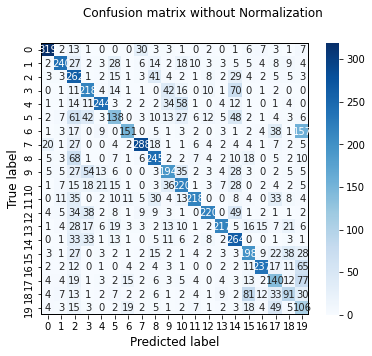

In [39]:
plot_confusion_matrix(y_test,predictions)